## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [1]:
import pandas as pd

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

Q1: We would do an analysis of which words appear to show up more often in scam emails, and then, given a new email which is not categorized, we would see if it has a high correlation with scam or non scam. We assign some value to words, and if an email has a high numeric similarity, this is how we predict whether something fits into one category or another.

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

<Axes: >

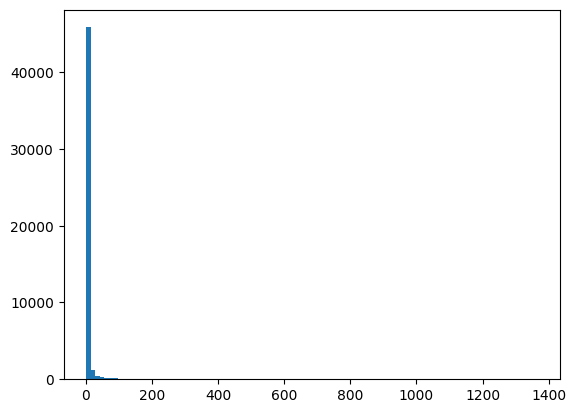

In [5]:
import pickle

with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

Q2: It would seem that most of our words dont show up too often, and that the majority are only a few times.

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


df = pd.read_parquet('Phishing_clean.parquet', engine='fastparquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=125)

lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )    

train:  0.6208817543400202
test:  -0.0002683843254520646


In [16]:
import numpy as npreduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
318,100,1.609955e+13,1.609955e+13
33,2001,1.285942e+13,1.285942e+13
237,1999,-7.447622e+12,7.447622e+12
74,"2002,",6.028829e+12,6.028829e+12
2490,supplies!â,-5.951244e+12,5.951244e+12
...,...,...,...
66,hpl,1.373291e-04,1.373291e-04
263,syntax,3.910065e-05,3.910065e-05
2649,skills,1.525879e-05,1.525879e-05
221,query,1.525879e-05,1.525879e-05


Q3: It seems for the most part that the highest values are just years of some sort and numbers, as well as some words that maybe have a higher chance of ending in an exclamation point? Often scam emails do tend to be overly enthusiastic, so this might be of some legitimacy. 

### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

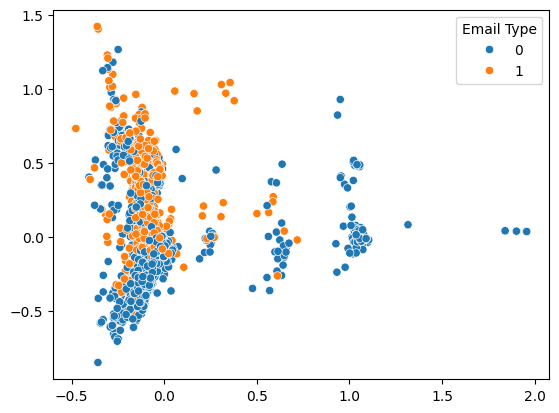

In [19]:
from sklearn.decomposition import PCA
import seaborn as sns

reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

Q4: It appears that the majority of our scams tend toward low X axis and middle-high Y axis.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [20]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )    

Train r2:  0.6928975360963752
Test r2:  0.5873905973217183


Q5: It seems to be much more accurate than before.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

PCA is inherently built for large dimension data, as it is meant to reduce down to only variables which have a high correlation on the effect of the prediction. On the other hand, if there isn't a lot of correlation between variables, PCA can be hard to use effectively.